In [176]:
# 基于py3.10
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight,compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn import  metrics
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import regularizers
from keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.over_sampling import SMOTE

In [31]:
# 导入数据
data = pd.read_csv(r"D:/Code_Project/fc_Project/data.csv",encoding="gbk")

In [32]:
# 观察数据
data

,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,3.521200e+14,0,6,7,5.666667,3,2.166667,34,7,5.666667,...,0.939194,4.262371e-03,0.050817,0.0,0.007434,0.0,0,0,1,0
1,3.521200e+14,0,6,4,2.500000,2,1.333333,15,4,2.500000,...,0.955626,2.981609e-03,0.030815,0.0,0.013398,0.0,0,0,1,0
2,3.521200e+14,8,6,8,6.166667,3,2.166667,45,9,7.500000,...,0.783610,3.321330e-04,0.000000,0.0,0.195087,0.0,0,0,0,0
3,3.521200e+14,0,6,6,3.666667,2,1.833333,23,6,3.833333,...,0.458649,1.843500e-04,0.000000,0.0,0.541351,0.0,0,0,0,0
4,3.521200e+14,0,6,5,4.333333,1,1.000000,26,5,4.333333,...,0.983726,3.163870e-04,0.000000,0.0,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,3.521280e+14,0,6,8,6.500000,3,3.000000,40,8,6.666667,...,0.986674,5.260850e-04,0.000000,0.0,0.013326,0.0,0,0,1,0
15996,3.521280e+14,0,6,8,6.833333,2,2.000000,42,9,7.000000,...,0.927005,6.890000e-05,0.008665,0.0,0.039553,0.0,1,0,0,0
15997,3.521280e+14,4,6,8,6.333333,2,2.000000,42,9,7.000000,...,0.773433,6.738972e-03,0.002232,1.0,0.223888,0.0,0,0,1,0
15998,3.521280e+14,0,6,5,3.333333,1,1.000000,20,5,3.333333,...,0.967045,7.680000e-07,0.025627,0.0,0.006425,0.0,0,0,0,0


In [33]:
# 删除脱敏且没有意义的列
Desensitized_meaningless_list = [
    '个人编码',
    '顺序号_NN',
    '交易时间DD_NN',
    '交易时间YYYY_NN',
    '交易时间YYYYMM_NN',
]
data = data.drop(Desensitized_meaningless_list,axis=1)

In [34]:
data.isnull().sum()
# 观察到存在缺失值的列,进行缺失值处理

一天去两家医院的天数    0
就诊的月数         0
月就诊天数_MAX     0
月就诊天数_AVG     0
月就诊医院数_MAX    0
             ..
个人支付治疗费用占比    0
BZ_民政救助       0
BZ_城乡优抚       0
是否挂号          0
RES           0
Length: 77, dtype: int64

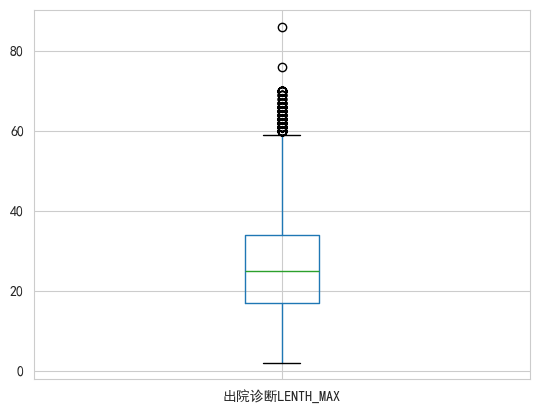

In [35]:
# 缺失值填充
emp_col = '出院诊断LENTH_MAX'
#  先观察箱图
data.boxplot(column=emp_col)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.show()

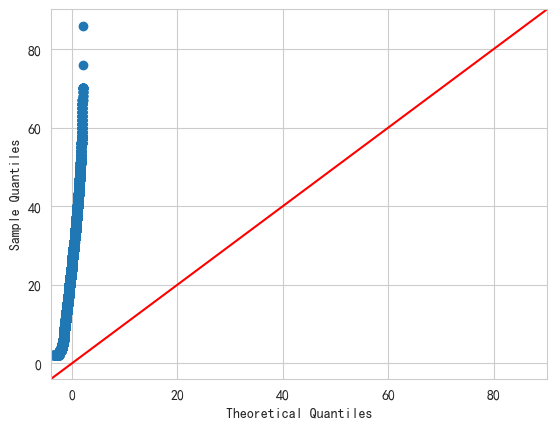

In [36]:
# 观察qq图
sm.qqplot(data[emp_col],line='45')
plt.show()
# 存在重尾情况或右偏情况，null值采用中位数进行填充

In [37]:
# 采用中位数进行数据填充
data[emp_col].fillna(np.median(data[~np.isnan(data[emp_col])]),inplace=True)
data[emp_col]

0        29.0
1        20.0
2        29.0
3        16.0
4        33.0
         ... 
15995    28.0
15996    25.0
15997    30.0
15998     5.0
15999    34.0
Name: 出院诊断LENTH_MAX, Length: 16000, dtype: float64

In [38]:
# 删除每列只有一种值的列
for col in data.columns.tolist():
    count = len(data[col].unique())
    print(count)
    if count==1:
        data = data.drop(col,axis=1)
# 只有一列被删除

65
7
31
224
8
52
190
57
267
15722
15936
15562
15856
137
485
15903
15960
15774
15888
9
1
15610
15936
15929
15548
15852
6890
15847
4983
13542
8479
3002
237
3410
362
5604
376
4968
45
5
44
157
136
7760
36
893
16
615
8
6665
26
15480
279
2
15918
344
2286
6035
15571
15938
2303
280
7
2277
10
30
72
15943
11428
12340
1229
15950
2454
2
2
2
2


In [39]:
# 删除重复的行
data.drop_duplicates(inplace=True)

In [40]:
data

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,0,6,7,5.666667,3,2.166667,34,7,5.666667,3501.18,...,0.939194,4.262371e-03,0.050817,0.0,0.007434,0.0,0,0,1,0
1,0,6,4,2.500000,2,1.333333,15,4,2.500000,2217.66,...,0.955626,2.981609e-03,0.030815,0.0,0.013398,0.0,0,0,1,0
2,8,6,8,6.166667,3,2.166667,45,9,7.500000,3360.55,...,0.783610,3.321330e-04,0.000000,0.0,0.195087,0.0,0,0,0,0
3,0,6,6,3.666667,2,1.833333,23,6,3.833333,3030.61,...,0.458649,1.843500e-04,0.000000,0.0,0.541351,0.0,0,0,0,0
4,0,6,5,4.333333,1,1.000000,26,5,4.333333,2332.45,...,0.983726,3.163870e-04,0.000000,0.0,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,6,8,6.500000,3,3.000000,40,8,6.666667,2831.13,...,0.986674,5.260850e-04,0.000000,0.0,0.013326,0.0,0,0,1,0
15996,0,6,8,6.833333,2,2.000000,42,9,7.000000,2369.03,...,0.927005,6.890000e-05,0.008665,0.0,0.039553,0.0,1,0,0,0
15997,4,6,8,6.333333,2,2.000000,42,9,7.000000,5421.56,...,0.773433,6.738972e-03,0.002232,1.0,0.223888,0.0,0,0,1,0
15998,0,6,5,3.333333,1,1.000000,20,5,3.333333,5270.74,...,0.967045,7.680000e-07,0.025627,0.0,0.006425,0.0,0,0,0,0


In [41]:
## 进行异常值处理

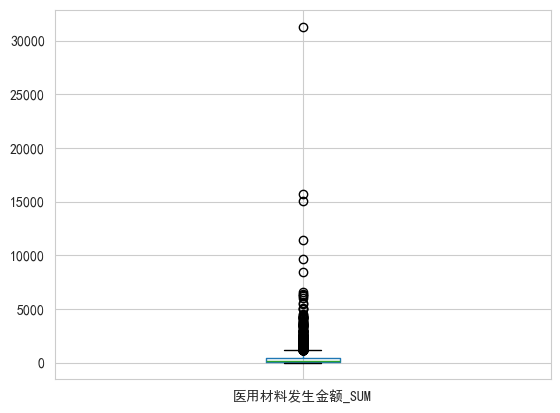

In [42]:
# 1，画箱线图
data.boxplot(column='医用材料发生金额_SUM')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.show()
# 发现多数的列呈右偏，故此处不用箱图进行异常值处理，采用缩尾处理

In [43]:
# 采用缩尾处理
for col in data.columns:
    if data[col].dtype is np.dtype('int64'):    #不对离散类型数据进行该处理
        continue
    df = data[col].tolist()
    def Winsorization_outliers(df):
        q1 = np.percentile(df,1)
        q3 = np.percentile(df,99)
        data.col[data.col>q3]=q3
        data.col[data.col<q1]=q1

In [44]:
data

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,0,6,7,5.666667,3,2.166667,34,7,5.666667,3501.18,...,0.939194,4.262371e-03,0.050817,0.0,0.007434,0.0,0,0,1,0
1,0,6,4,2.500000,2,1.333333,15,4,2.500000,2217.66,...,0.955626,2.981609e-03,0.030815,0.0,0.013398,0.0,0,0,1,0
2,8,6,8,6.166667,3,2.166667,45,9,7.500000,3360.55,...,0.783610,3.321330e-04,0.000000,0.0,0.195087,0.0,0,0,0,0
3,0,6,6,3.666667,2,1.833333,23,6,3.833333,3030.61,...,0.458649,1.843500e-04,0.000000,0.0,0.541351,0.0,0,0,0,0
4,0,6,5,4.333333,1,1.000000,26,5,4.333333,2332.45,...,0.983726,3.163870e-04,0.000000,0.0,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,6,8,6.500000,3,3.000000,40,8,6.666667,2831.13,...,0.986674,5.260850e-04,0.000000,0.0,0.013326,0.0,0,0,1,0
15996,0,6,8,6.833333,2,2.000000,42,9,7.000000,2369.03,...,0.927005,6.890000e-05,0.008665,0.0,0.039553,0.0,1,0,0,0
15997,4,6,8,6.333333,2,2.000000,42,9,7.000000,5421.56,...,0.773433,6.738972e-03,0.002232,1.0,0.223888,0.0,0,0,1,0
15998,0,6,5,3.333333,1,1.000000,20,5,3.333333,5270.74,...,0.967045,7.680000e-07,0.025627,0.0,0.006425,0.0,0,0,0,0


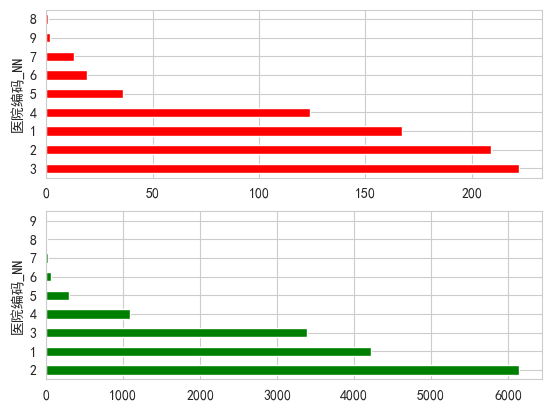

In [45]:
# 进行特征分析
col_1='医院编码_NN'
figure,ax = plt.subplots(2,1)
col_11_count = data.医院编码_NN[data['RES']==1].value_counts()
col_11_count.plot(ax=ax[0],kind='barh',color='red')
col_10_count = data.医院编码_NN[data['RES']==0].value_counts()
col_10_count.plot(kind='barh',label='0',ax=ax[1],color='green')
plt.show()
# 诈骗不同医院的就诊人数图
# 红色是欺诈（RES为1）

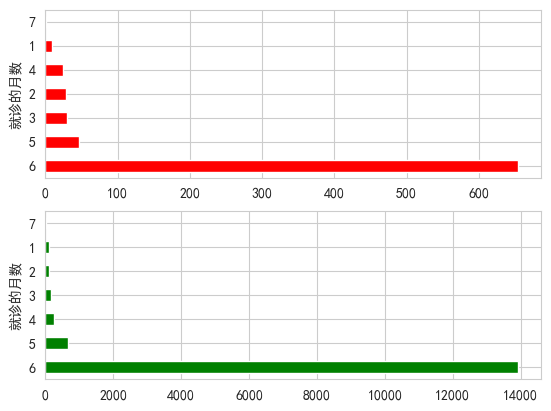

In [46]:
# 同理对就诊月数分析
col_2 = '就诊的月数'
_,ax = plt.subplots(2,1)
col_21_count = data.就诊的月数[data['RES']==1].value_counts()
col_21_count.plot(kind='barh',color='red',ax=ax[0])
col_20_count = data.就诊的月数[data['RES']==0].value_counts()
col_20_count.plot(kind='barh',color='green',ax=ax[1])
plt.show()

RES
0    15206
1      793
Name: count, dtype: int64


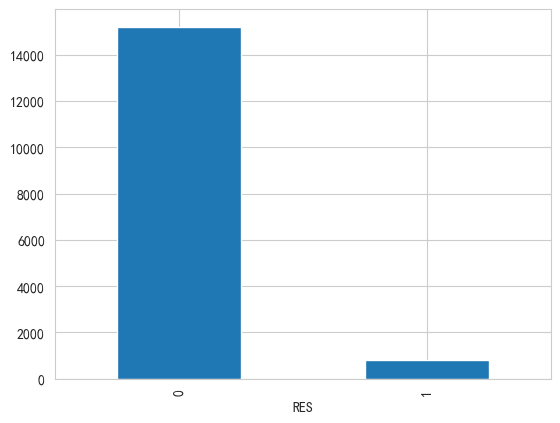

In [47]:
# 观察RES的分布情况
res_count = data["RES"].value_counts()
print(res_count)
res_count.plot(kind='bar')
plt.show()

In [48]:
## 使用筛选器法，去除高度相关的特征列（90%以上），使用皮尔逊系数
# 观察相关系数矩阵
target = 'RES'
feature = [x for x in data.columns if x not in target]
data_matrix = data[feature].corr()
plt.figure(figsize=(100, 100))
sns.heatmap(data_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

D:\anaconda3\envs\py10\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\envs\py10\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


In [49]:
def remove_highly_correlated_columns(df, threshold=0.90):
    """
    删除高度相关的列
    """
    # 计算相关系数矩阵
    corr_matrix = df.corr().abs()

    # 找到高度相关的列
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # 删除高度相关的列
    df = df.drop(to_drop, axis=1)

    return df

In [50]:
data_del_high = remove_highly_correlated_columns(data[feature],threshold=0.9)

In [51]:
data_del_high= pd.concat([data_del_high,data[target]],axis=1)
data_del_high

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊医院数_MAX,月统筹金额_MAX,月统筹金额_AVG,月药品金额_MAX,医院_就诊天数_MAX,医院_就诊天数_AVG,医院_统筹金_MAX,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,0,6,7,3,3501.18,2541.293333,3901.45,20,11.333333,7553.00,...,0.939194,4.262371e-03,0.050817,0.0,0.007434,0.0,0,0,1,0
1,0,6,4,2,2217.66,1637.358333,2449.13,13,7.500000,9500.07,...,0.955626,2.981609e-03,0.030815,0.0,0.013398,0.0,0,0,1,0
2,8,6,8,3,3360.55,2583.053333,3302.06,23,15.000000,9161.73,...,0.783610,3.321330e-04,0.000000,0.0,0.195087,0.0,0,0,0,0
3,0,6,6,2,3030.61,2057.720000,1500.12,17,11.500000,11622.17,...,0.458649,1.843500e-04,0.000000,0.0,0.541351,0.0,0,0,0,0
4,0,6,5,1,2332.45,2196.315000,2563.26,26,26.000000,13177.89,...,0.983726,3.163870e-04,0.000000,0.0,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,6,8,3,2831.13,2139.513333,3121.72,19,13.333333,7094.15,...,0.986674,5.260850e-04,0.000000,0.0,0.013326,0.0,0,0,1,0
15996,0,6,8,2,2369.03,2070.225000,2133.65,28,21.000000,9697.88,...,0.927005,6.890000e-05,0.008665,0.0,0.039553,0.0,1,0,0,0
15997,4,6,8,2,5421.56,3975.686667,4897.23,24,21.000000,12453.45,...,0.773433,6.738972e-03,0.002232,1.0,0.223888,0.0,0,0,1,0
15998,0,6,5,1,5270.74,3711.088333,6289.22,20,20.000000,22266.53,...,0.967045,7.680000e-07,0.025627,0.0,0.006425,0.0,0,0,0,0


In [52]:
## 进行RFR和XGBoost加权排序

In [112]:
# 进行标准化(只对连续型进行)
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
for col in data_del_high.columns:
    # if data[col].dtype is np.dtype('int64'):    #不对离散类型数据进行该处理
    #     continue
    data_del_high[col] = mm_scaler.fit_transform(data_del_high[col].values.reshape(-1, 1))

In [113]:
feature_ch = [x for x in data_del_high.columns if x not in target]
x = data_del_high[feature_ch].values
y = data_del_high[target].values

In [118]:
x

array([[0.        , 0.83333333, 0.2       , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.83333333, 0.1       , ..., 0.        , 0.        ,
        1.        ],
       [0.07407407, 0.83333333, 0.23333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03703704, 0.83333333, 0.23333333, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.83333333, 0.13333333, ..., 0.        , 0.        ,
        0.        ],
       [0.06481481, 0.83333333, 0.4       , ..., 0.        , 0.        ,
        0.        ]])

In [119]:
y

array([0., 0., 0., ..., 0., 0., 1.])

In [120]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 14)

In [131]:
pd.value_counts(y_train)

C:\Users\gaoxiangwei\AppData\Local\Temp\ipykernel_13928\3902155716.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_train)


0.0    10641
1.0      558
Name: count, dtype: int64

In [121]:
# Create a Contractive Autoencoder to generate synthetic fraud data
disable_eager_execution()
input_dim = x_train.shape[1]
encoding_dim = int(input_dim / 2)

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='sigmoid')(decoder)

# Define the Contractive loss function
def contractive_loss(y_true, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)
    w = 1e-4 # weight given to the jacobian regularizer
    contractive_reg = K.sum(K.square(K.gradients(y_pred, encoder)[0]), axis=1)
    return mse + w * contractive_reg

autoencoder = Model(inputs=input_layer, outputs=decoder)

# Train the autoencoder on normal transactions
X_normal = x_train[y_train == 0]
X_normal_train, X_normal_test = train_test_split(X_normal, test_size=0.2, random_state=42)

autoencoder.compile(optimizer='adam', loss=contractive_loss,)
history = autoencoder.fit(X_normal_train, X_normal_train, epochs=100, batch_size=32, validation_data=(X_normal_test, X_normal_test))

# Generate synthetic fraud transactions using the trained autoencoder
X_fraud = x_train[y_train == 1]
synthetic_fraud = autoencoder.predict(X_fraud)

noise_factor = 0.2
encoded_normal_noisy = synthetic_fraud + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=synthetic_fraud.shape)
synthetic_fraud_data = autoencoder.predict(encoded_normal_noisy)

# Combine the synthetic fraud transactions with the original fraud transactions
X_fraud = np.vstack((X_fraud, synthetic_fraud_data))

# Combine the normal transactions with the fraud transactions
X_balanced = np.vstack((X_normal, X_fraud))
y_balanced = np.hstack((np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])))

Train on 8512 samples, validate on 2129 samples
Epoch 1/100
6976/8512 [=======================>......] - ETA: 0s - loss: 0.0698

D:\anaconda3\envs\py10\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8512/8512 [==============================] - 1s 105us/sample - loss: 0.0600 - val_loss: 0.0150
Epoch 2/100
8512/8512 [==============================] - 0s 33us/sample - loss: 0.0131 - val_loss: 0.0122
Epoch 3/100
8512/8512 [==============================] - 0s 34us/sample - loss: 0.0117 - val_loss: 0.0115
Epoch 4/100
8512/8512 [==============================] - 0s 34us/sample - loss: 0.0112 - val_loss: 0.0111
Epoch 5/100
8512/8512 [==============================] - 0s 36us/sample - loss: 0.0109 - val_loss: 0.0108
Epoch 6/100
8512/8512 [==============================] - 0s 35us/sample - loss: 0.0105 - val_loss: 0.0101
Epoch 7/100
8512/8512 [==============================] - 0s 36us/sample - loss: 0.0085 - val_loss: 0.0067
Epoch 8/100
8512/8512 [==============================] - 0s 35us/sample - loss: 0.0057 - val_loss: 0.0053
Epoch 9/100
8512/8512 [==============================] - 0s 34us/sample - loss: 0.0048 - val_loss: 0.0046
Epoch 10/100
8512/8512 [==============================] -

D:\anaconda3\envs\py10\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [130]:
pd.value_counts(y_balanced)

C:\Users\gaoxiangwei\AppData\Local\Temp\ipykernel_13928\1856131930.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_balanced)


0.0    10641
1.0     1116
Name: count, dtype: int64

In [134]:
smote = SMOTE(random_state=14)
X_train_balanced, y_train_balanced = smote.fit_resample(X_balanced, y_balanced)

In [124]:
print(res_count)

RES
0    15206
1      793
Name: count, dtype: int64


In [136]:
pd.value_counts(y_train_balanced)

C:\Users\gaoxiangwei\AppData\Local\Temp\ipykernel_13928\1362396897.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_train_balanced)


0.0    10641
1.0    10641
Name: count, dtype: int64

In [144]:
pd.value_counts(y_test)

C:\Users\gaoxiangwei\AppData\Local\Temp\ipykernel_13928\3565148537.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_test)


0.0    4565
1.0     235
Name: count, dtype: int64

In [163]:
# 先进行RF
# 观察默认情况下的效果
# 选用precision进行评估，TP/(TP+FP)
# 并使用sample_weight处理类不平衡
rf0 = RandomForestClassifier(oob_score=True, random_state=14)
sample_weight_rf00 = compute_sample_weight('balanced',
                                           y_train)
rf0.fit(x_train,y_train,sample_weight=sample_weight_rf00)
print (rf0.oob_score_)
sample_weight_rf01 = compute_sample_weight('balanced',
                                          y_test)
y_pred = rf0.predict(x_test)
print( "precision Score (Train): %f" % metrics.precision_score(y_true=y_test, y_pred=y_pred,
                                                               sample_weight=sample_weight_rf01))

0.9602643093133315
precision Score (Train): 0.988576


In [32]:
score = rf0.score(x_test, y_test)
print(score)

0.95875


In [ ]:
## 进行参数优化
# 首先对n_estimators进行网格搜索
param_test1 = {'n_estimators':[76,300,400,500]}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(oob_score=True, random_state=14,class_weight='balanced'),
                       param_grid = param_test1, scoring='precision',cv=5)
gsearch1.fit(x_train,y_train)
print( gsearch1.best_params_, gsearch1.best_score_)

In [ ]:
# 接着对决策树最大深度max_depth进行网格搜索
param_test2 = {'max_depth':[32,33,34,35,37,39,41]}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=76,oob_score=True,
                                                           random_state=14,class_weight='balanced'),
                        param_grid = param_test2, scoring='precision', cv=5)
gsearch2.fit(x_train,y_train)
print( gsearch2.best_params_, gsearch2.best_score_)

In [ ]:
rf1 = RandomForestClassifier(n_estimators= 76,
                             max_depth=39 ,oob_score=True,
                             random_state=14,class_weight='balanced')
rf1.fit(x_train,y_train)
print( rf1.oob_score_)
y_pred= rf1.predict(x_test)
print( "Precision Score (Train): %f" % metrics.precision_score(y_test, y_pred))

In [ ]:
# 下面再对内部节点再划分所需最小样本数min_samples_split和叶子节点最少样本数min_samples_leaf一起调参
param_test3 = {'min_samples_split':[2,3,4,6,7,8,9], 'min_samples_leaf':[1,3,4,6,7,8]}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 76, max_depth=39,
                                  oob_score=True, random_state=14,class_weight='balanced'),
   param_grid = param_test3, scoring='precision', cv=5)
gsearch3.fit(x_train,y_train)
print( gsearch3.best_params_, gsearch3.best_score_)

In [166]:
# 用搜索到的最佳参数，再看看最终的模型拟合,观察到精确率有所提高
rf2 = RandomForestClassifier(n_estimators= 76, max_depth=39, min_samples_split=2,
                                min_samples_leaf=1,oob_score=True, random_state=14)
sample_weight_rf20 = compute_sample_weight('balanced',
                                           y_train)
rf2.fit(x_train,y_train,sample_weight=sample_weight_rf20)
print (rf2.oob_score_)
sample_weight_rf2 = compute_sample_weight('balanced',
                                          y_test)
y_pred2=rf2.predict(x_test)
print( "precision Score (Train): %f" % metrics.precision_score(y_test, y_pred2,sample_weight=sample_weight_rf2))

0.9597285471917135
precision Score (Train): 0.990007


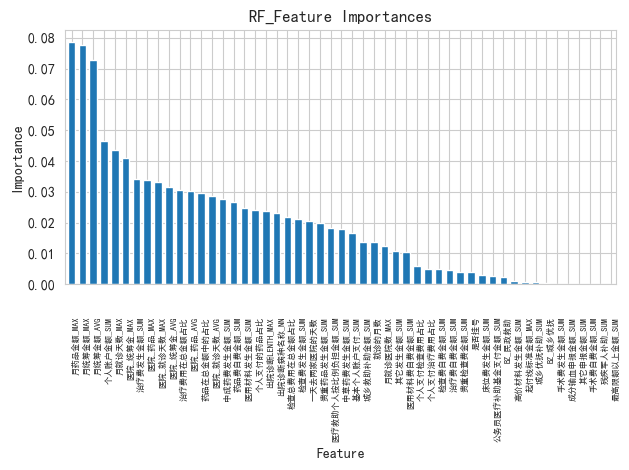

In [167]:
# 获取特征得分
rf2.fit(x,y)
_, ax = plt.subplots()
rf_importances = rf2.feature_importances_
feature_names = data_del_high.columns
sorted_indices = np.argsort(rf_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = [rf_importances[i] for i in sorted_indices]

ax.bar(range(len(sorted_importances)),sorted_importances,align='center',width=0.7)
ax.set_title("RF_Feature Importances")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
ax.set_xticks(range(len(sorted_feature_names)))
ax.set_xticklabels(sorted_feature_names, rotation=90, ha='right',rotation_mode='anchor',fontsize=6)
ax.tick_params(axis='x', pad=20)
ax.set_xlim(-0.6, len(sorted_feature_names) - 0.6)
plt.tight_layout()
plt.show()

In [168]:
feature_importance_df = pd.DataFrame({
    'Feature': sorted_feature_names,
    'rf_score': range(len(sorted_importances),0,-1),
    'Importance': sorted_importances
})
y_pre = rf2.predict(x)
print( "f1 Score (All): %f" % metrics.f1_score(y, y_pre))
feature_importance_df

f1 Score (All): 0.999369


,Feature,rf_score,Importance
0,月药品金额_MAX,51,0.078489
1,月统筹金额_MAX,50,0.077731
2,月统筹金额_AVG,49,0.072668
3,个人账户金额_SUM,48,0.046624
4,月就诊天数_MAX,47,0.043507
5,医院_统筹金_MAX,46,0.041065
6,治疗费发生金额_SUM,45,0.034050
7,医院_药品_MAX,44,0.033849
8,医院_就诊天数_MAX,43,0.033156
9,医院_统筹金_AVG,42,0.031730


The f1 of the XGBClassifier is: 0.584082119282328


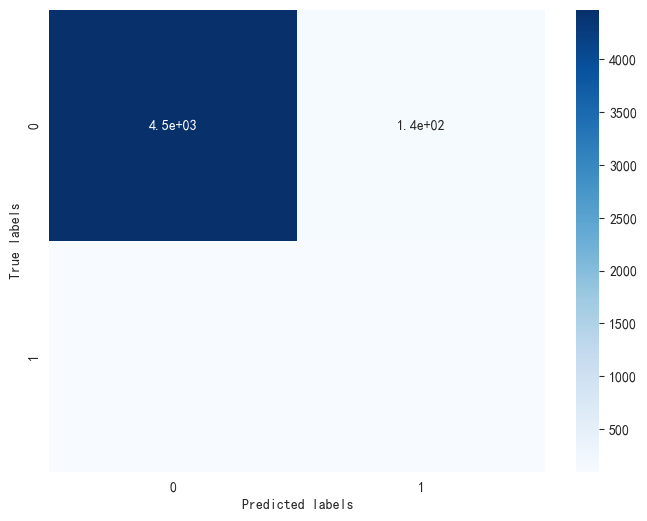

	预测结果评价报表：
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      4565
         1.0       0.51      0.42      0.46       235

    accuracy                           0.95      4800
   macro avg       0.74      0.70      0.72      4800
weighted avg       0.95      0.95      0.95      4800



In [175]:
xgb0 = XGBClassifier()
sample_weight_xgb01 = compute_sample_weight('balanced',
                                           y_train)
xgb0.fit(x_train,y_train,sample_weight=sample_weight_xgb01)
test_predict = xgb0.predict(x_test)
sample_weight_xgb02 = compute_sample_weight('balanced',
                                            y_test)
print('The f1 of the XGBClassifier is:',metrics.f1_score(y_test,test_predict,sample_weight=sample_weight_xgb02))
confusion_matrix_result = metrics.confusion_matrix(test_predict,y_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print("\t预测结果评价报表：\n", metrics.classification_report(y_test,test_predict))

In [186]:
# n_estimators调参
param_xgb_test1 = {'n_estimators':[i for i in range(20,90,10)]
                   }
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 max_depth=5,
                                                 max_delta_step=1,
                                                 min_child_weight=1,
                                                 gamma=0,
                                                 subsample=0.8,
                                                 colsample_bytree=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test1,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('max_depth_min_child_weight')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

max_depth_min_child_weight
gsearch1.best_params_ {'n_estimators': 40}
gsearch1.best_score_ 0.7963566654732068


In [193]:
# max_depth和min_child_weight参数调优
# max_depth和min_child_weight参数对最终结果有很大的影响。max_depth通常在3-10之间，min_child_weight。采用grid search，我们先大
# 范围地粗略参数，然后再小范围的微调。
param_xgb_test2 = {'max_depth':[i for i in range(3,10,1)],
                   'min_child_weight':[i for i in range(1,8,1)]
                   }
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=40,
                                                 max_depth=5,
                                                 max_delta_step=1,
                                                 min_child_weight=1,
                                                 gamma=0,
                                                 subsample=0.8,
                                                 colsample_bytree=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test2,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('max_depth_min_child_weight')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

max_depth_min_child_weight
gsearch1.best_params_ {'max_depth': 3, 'min_child_weight': 3}
gsearch1.best_score_ 0.8085767372723895


In [194]:
# gamma参数调优
param_xgb_test3 = {'gamma':[i/10.0 for i in range(0,10)]}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=40,
                                                 max_depth=3,
                                                 max_delta_step=1,
                                                 min_child_weight=3,
                                                 subsample=0.8,
                                                 colsample_bytree=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test3,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('gamma')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

gamma
gsearch1.best_params_ {'gamma': 0.0}
gsearch1.best_score_ 0.8085767372723895


In [195]:
# 调整subsample 和 colsample_bytree参数
param_xgb_test4 = {'subsample':[i/10.0 for i in range(2,10)],
                   'colsample_bytree':[i/10.0 for i in range(2,10)]
                   }
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=40,
                                                 max_depth=3,
                                                 max_delta_step=1,
                                                 min_child_weight=3,
                                                 gamma=0,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test4,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('subsample & colsample_bytree')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

subsample & colsample_bytree
gsearch1.best_params_ {'colsample_bytree': 0.2, 'subsample': 0.5}
gsearch1.best_score_ 0.8607142857142858


In [200]:
param_xgb_test5 = {'max_delta_step':[x for x in range(1,40,1)]}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=40,
                                                 max_depth=3,
                                                 min_child_weight=3,
                                                 subsample=0.5,
                                                 colsample_bytree=0.2,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test5,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('max_delta_step')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

max_delta_step
gsearch1.best_params_ {'max_delta_step': 1}
gsearch1.best_score_ 0.8607142857142858


In [202]:
#正则化参数调优reg_alpha
param_xgb_test6 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=40,
                                                 max_depth=3,
                                                 min_child_weight=3,
                                                 max_delta_step=1,
                                                 subsample=0.5,
                                                 colsample_bytree=0.2,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test6,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('reg_alpha')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

reg_alpha
gsearch1.best_params_ {'reg_alpha': 1e-05}
gsearch1.best_score_ 0.8607142857142858


In [204]:
param_xgb_test7 = {'reg_lambda':[x for x in range(50,150,10)]}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=40,
                                                 max_depth=3,
                                                 min_child_weight=3,
                                                 reg_alpha=1e-05,
                                                 max_delta_step=1,
                                                 subsample=0.5,
                                                 colsample_bytree=0.2,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test7,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('reg_lambda')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

reg_lambda
gsearch1.best_params_ {'reg_lambda': 140}
gsearch1.best_score_ 0.9384615384615385


The precision of the XGBClassifier is: 0.9285714285714286


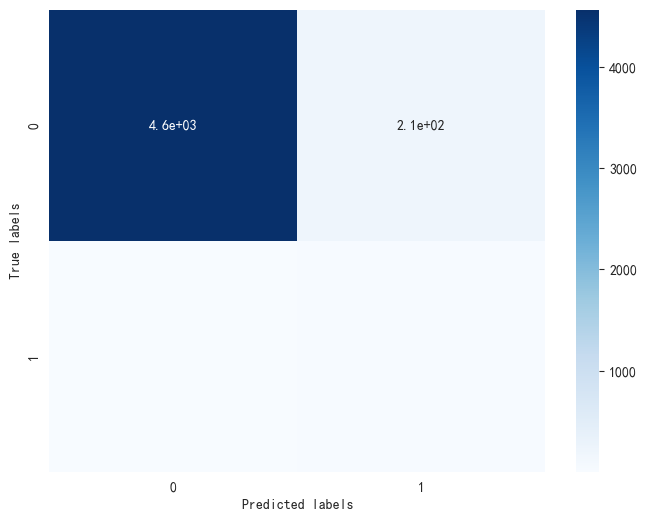

	预测结果评价报表：
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      4565
         1.0       0.93      0.11      0.20       235

    accuracy                           0.96      4800
   macro avg       0.94      0.56      0.59      4800
weighted avg       0.95      0.96      0.94      4800



In [208]:
xgb1=XGBClassifier(learning_rate =0.1,
                   n_estimators=40,
                   max_depth=3,
                   min_child_weight=3,
                   reg_alpha=1e-05,
                   reg_lambda=140,
                   max_delta_step=1,
                   subsample=0.5,
                   colsample_bytree=0.2,
                   objective= 'binary:logistic',
                   nthread=4,
                   seed=14)
xgb1.fit(x_train,y_train)
test_predict1 = xgb1.predict(x_test)
print('The precision of the XGBClassifier is:',metrics.precision_score(y_test,test_predict1))
confusion_matrix_result = metrics.confusion_matrix(test_predict1,y_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print("\t预测结果评价报表：\n", metrics.classification_report(y_test,test_predict1))